In [1]:
import torch

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


#Generate data

In [3]:
import random
lstX = []
lstY = []
for x in range(-200, 200, 5):
  lstX.append([x])
  y = 3*x + random.uniform(0, 1)*100
  lstY.append([y])

In [4]:
import numpy as np
numpyX = np.array(lstX)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(80, 1) (80, 1)


In [9]:
#Split data to train (80%) and test (20%)
from sklearn.model_selection import train_test_split
trainX, testX, trainY_hat, testY_hat = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY_hat.shape, testY_hat.shape)

(64, 1) (16, 1) (64, 1) (16, 1)


In [10]:
#randomly split the training set again to train (80%*0.8)  and validation (80%*0.2)
trainX, validX, trainY_hat, validY_hat = train_test_split(trainX, trainY_hat, test_size=0.20, random_state=0)
print(trainX.shape, validX.shape, trainY_hat.shape, validY_hat.shape)

(51, 1) (13, 1) (51, 1) (13, 1)


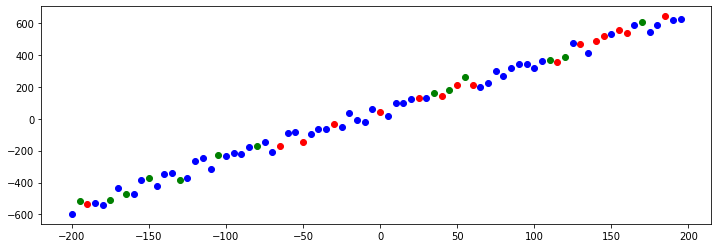

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.scatter(trainX, trainY_hat, color = "blue")
plt.scatter(validX, validY_hat, color = "green")
plt.scatter(testX, testY_hat, color = "red")
plt.show()

# Build NN

In [12]:
import torch.nn as nn

In [13]:
MyNet = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
)
MyNet.to(device)
print(MyNet)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


In [14]:
from torchsummary import summary
summary(MyNet, input_size=(10, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 10, 100]             200
              ReLU-2              [-1, 10, 100]               0
            Linear-3               [-1, 10, 50]           5,050
              ReLU-4               [-1, 10, 50]               0
            Linear-5                [-1, 10, 1]              51
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [15]:
loss_func = torch.nn.MSELoss()

In [16]:
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.005)

# Train N epoches

In [17]:
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_trainY_hat = torch.FloatTensor(trainY_hat).to(device)
tensor_validX = torch.FloatTensor(validX).to(device)
tensor_validY_hat = torch.FloatTensor(validY_hat).to(device)

In [18]:
# Early stopping
the_last_loss = 100000
patience = 2
trigger_times = 0
trainLossLst = []
validLossLst = []
for epoch in range(1, 500):
    tensor_trainY = MyNet(tensor_trainX)
    train_loss = loss_func(tensor_trainY, tensor_trainY_hat)
    trainLossLst.append(float(train_loss))
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    tensor_validY = MyNet(tensor_validX)
    valid_loss = loss_func(tensor_validY, tensor_validY_hat)
    validLossLst.append(float(valid_loss))

    #early stop
    the_current_loss = float(valid_loss)
    if(the_current_loss > the_last_loss):
      trigger_times += 1
      print('trigger times:', trigger_times)
      if trigger_times >= patience:
        print('Early stopping!')
        break  # early stop when valid loss drops 2 consective times
    elif(trigger_times >0):
      print('trigger times reset to 0')
      trigger_times = 0
    the_last_loss = the_current_loss

trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times: 2
Early stopping!


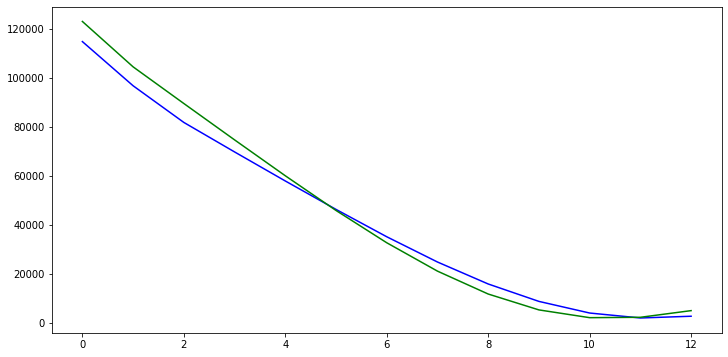

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(trainLossLst, color="blue")
plt.plot(validLossLst, color="green")
plt.show()

##Training data performance

In [20]:
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_trainY_hat = torch.FloatTensor(trainY_hat).to(device)
tensor_trainY = MyNet(tensor_trainX)
loss = loss_func(tensor_trainY, tensor_trainY_hat)
print("%.2f" % (float(loss)))

5393.46


In [21]:
trainY = tensor_trainY.detach().cpu().numpy()

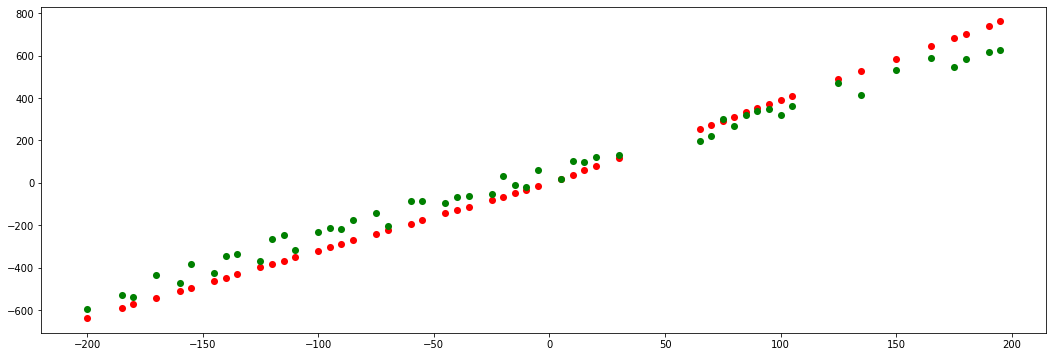

In [22]:
plt.figure(figsize=(18, 6))
plt.scatter(trainX, trainY, s=50, lw=0, color="red")
plt.scatter(trainX, trainY_hat, s=50, lw=0, color="green")
plt.show()

# Test 

In [23]:
tensor_testX = torch.FloatTensor(testX).to(device)
tensor_testY_hat = torch.FloatTensor(testY_hat).to(device)
tensor_testY = MyNet(tensor_testX)
loss = loss_func(tensor_testY, tensor_testY_hat)
print("%.2f" % (float(loss)))

2990.17


In [24]:
testY = tensor_testY.detach().cpu().numpy()

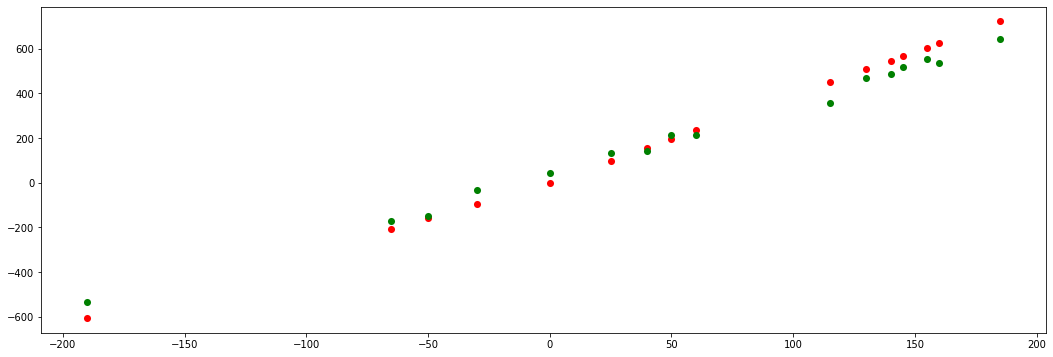

In [25]:
plt.figure(figsize=(18, 6))
plt.scatter(testX, testY, s=50, lw=0, color="red")
plt.scatter(testX, testY_hat, s=50, lw=0, color="green")
plt.show()